Implements DCGAN, source: https://arxiv.org/pdf/1511.06434.pdf

Notes:
- for faces: CelebA

In [1]:
import torch
import torch.nn as nn
import numpy as np
import os

from matplotlib import pyplot as plt
from constants import REPO_DIR
from utils import get_saved_model, load_model

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.latent_dims = latent_dims
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True),
            nn.Unflatten(dim=1, 
            unflattened_size=(32, 3, 3)),
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
    
    def forward(self, x):
        return self.decoder(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.discriminator = nn.Sequential(
        nn.Conv2d(1, 8, 3, stride=2, padding=1),
        nn.ReLU(True),
        nn.Conv2d(8, 16, 3, stride=2, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(True),
        nn.Conv2d(16, 32, 3, stride=2, padding=0),
        nn.ReLU(True),
        nn.Flatten(start_dim=1),
        nn.Linear(3 * 3 * 32, 128),
        nn.ReLU(True),
        nn.Linear(128, 16),
        nn.ReLU(True),
        nn.Linear(16, 1),
        nn.Sigmoid()
    )

    def forward(self, x):
        return self.discriminator(x)

In [9]:
from utils import mnist_training_set

def retrain_model():
    """
    @returns: retrains new model
    """
    num_epochs = 5
    batch_size = 16
    real_label = 1
    fake_label = 0
    fake_latent_dims = 16
    dataloader = torch.utils.data.DataLoader(mnist_training_set, batch_size=batch_size, shuffle=True)
    loss_fn = nn.BCELoss()
    distribution = torch.distributions.Normal(0.5, 0.3)

    generator = Generator(fake_latent_dims).cpu()
    discriminator = Discriminator().cpu()
    generator_optimizer = torch.optim.Adam(generator.parameters(),weight_decay=1e-5)
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(),weight_decay=1e-5)

    for epoch in range(num_epochs):
        discriminator_epoch_loss = 0
        generator_epoch_loss = 0
        for data in dataloader:
            #discriminator
            discriminator_optimizer.zero_grad()
            #loss on real data
            real_input, _ = data
            real_input = real_input.reshape(batch_size, 1, 28, 28)
            real_output = discriminator(real_input).view(-1)
            real_labels = torch.full_like(real_output, real_label)
            real_loss = loss_fn(real_output, real_labels)
            #loss on fake (generated) data
            fake_latent_input = distribution.sample((batch_size,fake_latent_dims)).clamp(0,1)
            # pass through generator and remove gradient so backprop only passes through discriminator
            fake_input = generator(fake_latent_input).detach() 
            fake_output = discriminator(fake_input).view(-1)
            fake_labels = torch.full_like(fake_output, fake_label)
            fake_loss = loss_fn(fake_output, fake_labels)
            #total loss
            discriminator_loss = real_loss + fake_loss
            discriminator_epoch_loss += discriminator_loss.item()
            discriminator_loss.backward()
            discriminator_optimizer.step()

            #generator
            generator_optimizer.zero_grad()
            fake_latent_input = distribution.sample((batch_size, fake_latent_dims)).clamp(0,1)
            fake_output = discriminator(generator(fake_latent_input)).view(-1)
            real_labels = torch.full_like(fake_output, real_label)
            generator_loss = loss_fn(fake_output, real_labels)
            generator_epoch_loss += generator_loss.item()
            generator_loss.backward()
            generator_optimizer.step()
        print(f'epoch [{epoch+1}/{num_epochs}], generator_loss:{generator_epoch_loss}, discriminator loss:{discriminator_epoch_loss}')
    return generator.eval(), discriminator.eval()
    

In [10]:
generator, discriminator = retrain_model()

epoch [1/5], generator_loss:21080.888873279095, discriminator loss:547.8061278223659
epoch [2/5], generator_loss:25320.726028442383, discriminator loss:216.08190569917082
epoch [3/5], generator_loss:31593.809960603714, discriminator loss:73.97914843146961
epoch [4/5], generator_loss:34428.0429494977, discriminator loss:96.01765418550875
epoch [5/5], generator_loss:46581.11692022532, discriminator loss:87.37648380000418


In [13]:
save_gan(discriminator, generator)

In [12]:
GAN_DISCRIMINATOR_MNIST_WEIGHT_PATH = os.path.join(REPO_DIR, 'architectures', 'weights', 'gan_discriminator_mnist_state_dict.pt')
GAN_GENERATOR_MNIST_WEIGHT_PATH = os.path.join(REPO_DIR, 'architectures', 'weights', 'gan_generator_mnist_state_dict.pt')

def save_gan(discriminator, generator, discriminator_weight_path=GAN_DISCRIMINATOR_MNIST_WEIGHT_PATH, generator_weight_path = GAN_GENERATOR_MNIST_WEIGHT_PATH):
    """
    todo
    """
    if not os.path.isfile(discriminator_weight_path):
        os.makedirs(os.path.dirname(discriminator_weight_path), exist_ok = True)
    if not os.path.isfile(generator_weight_path):
        os.makedirs(os.path.dirname(generator_weight_path), exist_ok = True)
    torch.save(discriminator.state_dict(), discriminator_weight_path)
    torch.save(generator.state_dict(), generator_weight_path)


def load_saved_gan(discriminator_weight_path=GAN_DISCRIMINATOR_MNIST_WEIGHT_PATH, generator_weight_path = GAN_GENERATOR_MNIST_WEIGHT_PATH):
    """
    todo
    @returns: discriminator, generator
    """
    return get_saved_model(Discriminator, discriminator_weight_path), get_saved_model(Generator, generator_weight_path)

In [21]:
import torchvision.utils as vutils

def show_examples(generator, num_examples = 20):
    distribution = torch.distributions.Normal(0.5, 0.3)
    latent_input = distribution.sample((num_examples, 16)).clamp(0,1)
    generated_images = generator(latent_input).detach()
    plt.imshow(np.transpose(vutils.make_grid(generated_images, padding=2, normalize=True).cpu(),(1,2,0)))

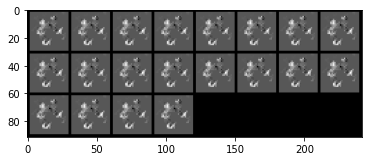

In [22]:
show_examples(generator)